# Import section

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import lightgbm
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [25]:
sns.set()
sns.set_style('white', {'axes.grid': False, 'axes.edgecolor': '0.9'})

# Read data

In [2]:
ex21 = pd.read_feather('ex21.feather')
ex21.head()

,SUBS_ID,STATUS,DATE_OF_BIRTH,GNDR_ID,COUNT(PT.PAY_ID),PAYMENT,CHARGE,UNKNOWN1,UNKNOWN2,CNT_contacts,android,ios,web,oses,year,month,day,woy,dow,status_encoded
0,593,"""Активен""",2017-09-30,1.0,65700,824394402.0,12746649.0,27.0,-1.0,0,0,0,0,0,2017.0,9.0,30.0,39.0,5.0,0
1,161292,"""Активен""",NaT,1.0,380,22800000.0,103856.0,296.0,-1.0,0,0,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,0
2,161306,"""Активен""",NaT,1.0,380,22800000.0,103856.0,296.0,-1.0,0,1,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,0
3,13340,"""Активен""",1983-11-04,-1.0,3640,1059972.0,7008.0,1358069.0,979.0,0,1,0,1,2,1983.0,11.0,4.0,44.0,4.0,0
4,249,"""Активен""",2017-09-30,1.0,65700,824394402.0,12746649.0,27.0,-1.0,0,0,0,0,0,2017.0,9.0,30.0,39.0,5.0,0


# Preprocess

In [3]:
columns = list(ex21.columns)
for col in ['SUBS_ID', 'STATUS', 'DATE_OF_BIRTH', 'status_encoded']:
    columns.remove(col)

In [4]:
rate1 = int(np.round(len(ex21[ex21.status_encoded == 0]) / len(ex21[ex21.status_encoded == 1]), 0))
rate2 = int(np.round(len(ex21[ex21.status_encoded == 0]) / len(ex21[ex21.status_encoded == 2]), 0))
rate3 = int(np.round(len(ex21[ex21.status_encoded == 0]) / len(ex21[ex21.status_encoded == 3]), 0))

In [9]:
ex21 = pd.concat([ex21[ex21.status_encoded == 1]] * rate1 + [ex21], ignore_index = True)
ex21 = pd.concat([ex21[ex21.status_encoded == 2]] * rate2 + [ex21], ignore_index = True)
ex21 = pd.concat([ex21[ex21.status_encoded == 3]] * rate3 + [ex21], ignore_index = True)

In [10]:
len(ex21)

380010

In [12]:
kf = StratifiedShuffleSplit(n_splits=1, test_size = 0.25)
X = ex21[columns].copy()
y = ex21['status_encoded']
folds = list(kf.split(X, y))

xfold0_train, xfold0_test = X.iloc[folds[0][0], :], X.iloc[folds[0][1], :]
yfold0_train, yfold0_test = y[folds[0][0]], y[folds[0][1]]

# Model

In [18]:
param =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    # 'max_depth': 15,
    'num_leaves': 300,
    'feature_fraction': 0.65,
    'bagging_fraction': 0.75,
    # 'bagging_freq': 5,
    'learning_rate': 0.02,
    'verbose': 0, 'num_class': 4
} 

In [19]:
lgtrain = lightgbm.Dataset(xfold0_train, yfold0_train,
                    feature_name = columns)
lgeval = lightgbm.Dataset(xfold0_test, yfold0_test,
                    feature_name = columns)

lgb_clf = lightgbm.train(param, lgtrain,
    num_boost_round=1000,
    valid_sets=[lgtrain, lgeval],
    valid_names=['train','valid'],
    early_stopping_rounds=100,
    verbose_eval=100
)

Training until validation scores don't improve for 100 rounds.
[100]	train's multi_logloss: 0.351957	valid's multi_logloss: 0.359787
[200]	train's multi_logloss: 0.18284	valid's multi_logloss: 0.19279
[300]	train's multi_logloss: 0.132771	valid's multi_logloss: 0.143969
[400]	train's multi_logloss: 0.110845	valid's multi_logloss: 0.123016
[500]	train's multi_logloss: 0.0965176	valid's multi_logloss: 0.109142
[600]	train's multi_logloss: 0.0866786	valid's multi_logloss: 0.0996284
[700]	train's multi_logloss: 0.0788648	valid's multi_logloss: 0.0920737
[800]	train's multi_logloss: 0.0734027	valid's multi_logloss: 0.0871023
[900]	train's multi_logloss: 0.0689906	valid's multi_logloss: 0.0831228
[1000]	train's multi_logloss: 0.0651092	valid's multi_logloss: 0.079476
Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.0651092	valid's multi_logloss: 0.079476


In [20]:
yfold0_trainohc = pd.get_dummies(yfold0_train)
yfold0_testohc = pd.get_dummies(yfold0_test)

In [21]:
def fitprint(gbr, xtrain, ytrain,  xtest, ytest, ytrain_ohc, ytest_ohc, datacolumns = None):
    
    pred = gbr.predict(xtest, num_iteration=gbr.best_iteration)
    out = np.zeros(pred.shape, dtype=bool)
    out[np.arange(len(pred)), pred.argmax(axis=1)] = 1
    out = out * 1
    outlabels = pred.argmax(axis=1)
    
    predtrain = gbr.predict(xtrain, num_iteration=gbr.best_iteration)
    outtrain = np.zeros(predtrain.shape, dtype=bool)
    outtrain[np.arange(len(predtrain)), predtrain.argmax(axis=1)] = 1
    outtrain = outtrain * 1
    outtrainlabels = predtrain.argmax(axis=1)
    
    print('Logloss of classifier on train set: {:.4f}'
        .format(log_loss(ytrain_ohc, predtrain)))
    print('Logloss of classifier on testset: {:.4f}'
        .format(log_loss(ytest_ohc, pred)))
    
    pre = precision_score(ytest_ohc, out, average = 'macro')
    print('Precision score of classifier on test set: {:.4f}'.format(pre))
    
    re = recall_score(ytest_ohc, out, average = 'macro')
    print('Recall score of classifier on test set: {:.4f}'.format(re))
    
    f1 = f1_score(ytest_ohc, out, average = 'macro')
    print('F1 score of classifier on test set: {:.4f}'.format(f1))
    
    confm = confusion_matrix(ytest.values, out.argmax(axis = 1))
    print(confm)
    
    print('Accuracy of classifier on training set: {:.4f}'
         .format(accuracy_score(ytrain, outtrainlabels)))
    print('Accuracy of classifier on test set: {:.4f}'
         .format(accuracy_score(ytest, outlabels)))
    
    f, ax = plt.subplots(figsize=(7, 14))
    fdf = pd.DataFrame(data = list(gbr.feature_importance()), index = xtrain.columns).reset_index()
    fdf = fdf.rename(columns={fdf.columns[1]:"importance"})
    fdf = fdf.sort_values(by = ['importance'], ascending = False)
    fdf = fdf.iloc[0:10, :]
    
    if datacolumns is not None:
        fdf['index'] = fdf['index'].apply(lambda x: str(datacolumns[x]))
    fdf['index'] = fdf['index'].apply(lambda x: str(x)[0:50])
    print(fdf)
    sns.barplot(y = fdf['index'].astype(str), x = fdf['importance'],  ax = ax, palette = sns.color_palette("YlGnBu", n_colors=4))
    ax.set_title('feature importances')

Logloss of classifier on train set: 0.0651
Logloss of classifier on testset: 0.0795
Precision score of classifier on test set: 0.9806
Recall score of classifier on test set: 0.9800
F1 score of classifier on test set: 0.9801
[[22120  1201    50   103]
 [  163 24257     0   105]
 [    0     0 23489     0]
 [  272     0     0 23243]]
Accuracy of classifier on training set: 0.9856
Accuracy of classifier on test set: 0.9801
               index  importance
11              year      208885
13               day      195140
14               woy      191549
15               dow      120750
12             month      111799
2            PAYMENT       99987
3             CHARGE       56036
1   COUNT(PT.PAY_ID)       50672
0            GNDR_ID       44750
10              oses       31304


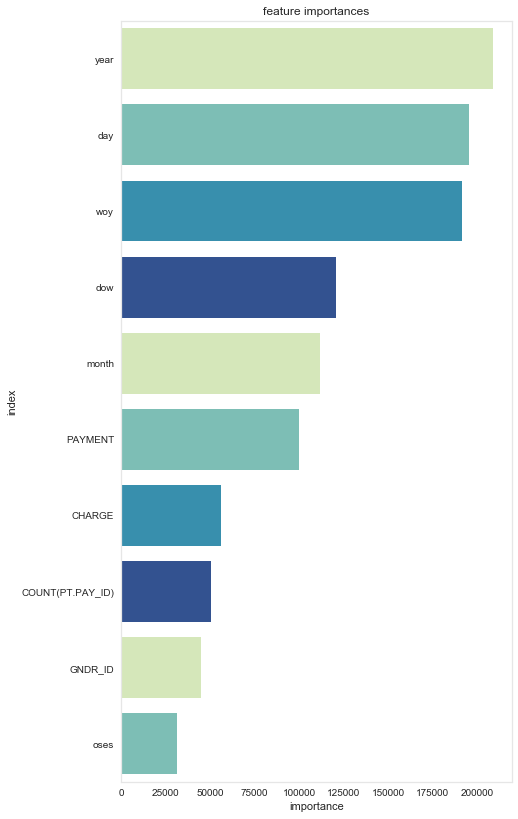

In [28]:
fitprint(lgb_clf, xfold0_train, yfold0_train,  xfold0_test, yfold0_test, yfold0_trainohc, yfold0_testohc, datacolumns = None)